=== Adopted Problem: 1D Constant-Velocity ===
device=cpu, dt=0.1, state=[pos, vel], measurement=pos only
F=
 [[1.  0.1]
 [0.  1. ]]
H=
 [[1. 0.]]
diag(Q_true) = [0.01 0.01] (q_scale=0.1)
diag(R_true) = [1.] (r_scale=1.0)
Base cov: gamma_Q=10.0, gamma_R=5.0
diag(Q_base) = [0.09999999 0.09999999]
diag(R_base) = [5.]

Epoch 01 | Train total: 0.291349 (MSE=0.290681) | Test MSE: 0.283664
Epoch 02 | Train total: 0.251359 (MSE=0.283249) | Test MSE: 0.270829
Epoch 03 | Train total: 0.185395 (MSE=0.271506) | Test MSE: 0.264374
Epoch 04 | Train total: 0.173868 (MSE=0.268556) | Test MSE: 0.263018
Epoch 05 | Train total: 0.172837 (MSE=0.267878) | Test MSE: 0.262451
Epoch 06 | Train total: 0.172090 (MSE=0.267367) | Test MSE: 0.261952
Epoch 07 | Train total: 0.171480 (MSE=0.266929) | Test MSE: 0.261545
Epoch 08 | Train total: 0.170912 (MSE=0.266503) | Test MSE: 0.261182
Epoch 09 | Train total: 0.170381 (MSE=0.266082) | Test MSE: 0.260942
Epoch 10 | Train total: 0.169953 (MSE=0.265788) | Test MSE: 0.

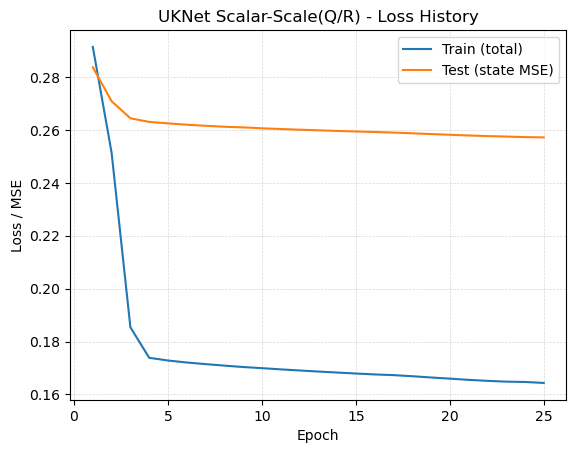


===== Final (Test Set) =====
UKNet MSE: 2.571596e-01
UKF  MSE: 2.870159e-01


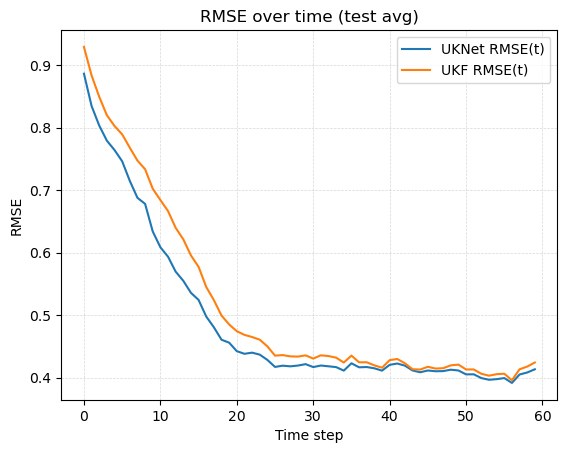

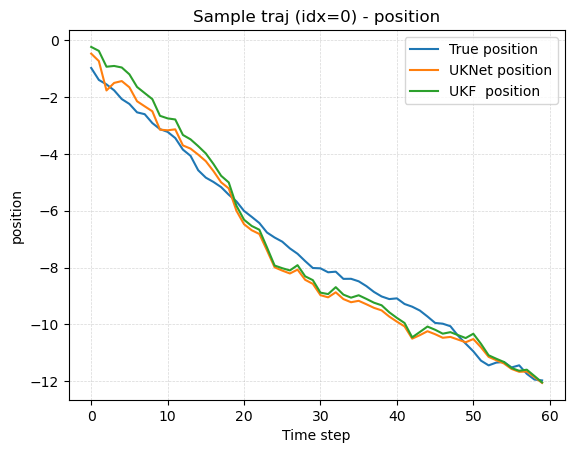

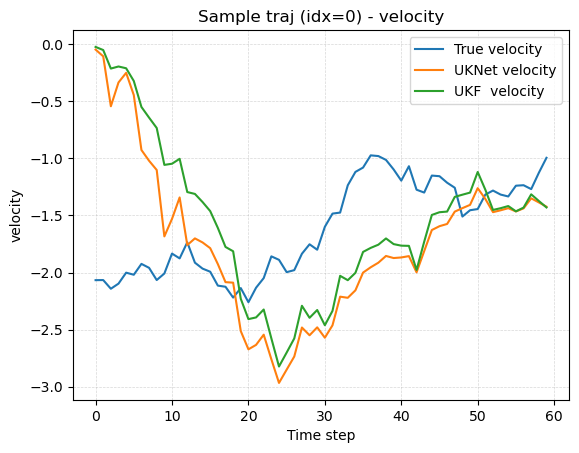

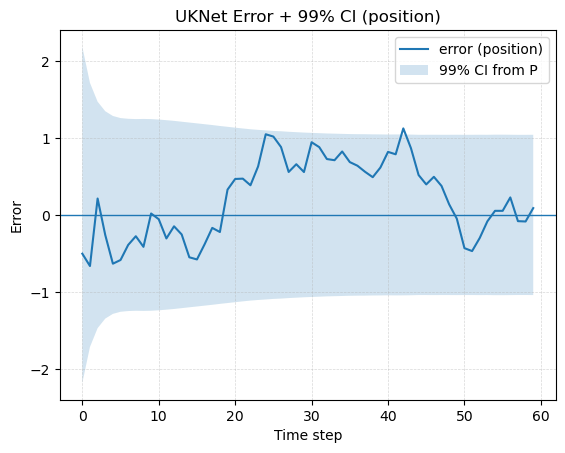

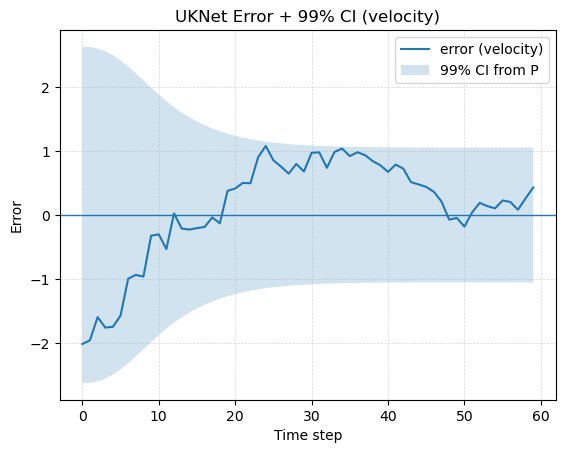

In [4]:
"""
UKNet (UKF + learned scalar scales for Q/R) on 1D Constant-Velocity (CV) model.

State: x_t = [position, velocity]^T (n=2)
Meas : y_t = position              (m=1)

Data gen uses Q_true, R_true (unknown to us).
Filter/training uses base covariances Q_base, R_base (typically larger),
and learns per-time-step scalar scales:
    Q_t = exp(sq_t) * Q_base
    R_t = exp(sr_t) * R_base

Training loss:
- state MSE
- optional covariance calibration via state NLL from P (Mahalanobis + logdet)

Final plots:
- Loss history
- RMSE over time (UKNet vs baseline UKF(Q_base,R_base))
- Sample trajectory (pos/vel)
- LAST PLOT: error per state with 99% CI band from P (± z * sqrt(P_ii)), z=2.5758
"""

import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List


# -------------------------
# Repro / device
# -------------------------
def set_seed(seed: int = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# -------------------------
# SPD / numerics (autograd-safe)
# -------------------------
def symmetrize(P: torch.Tensor) -> torch.Tensor:
    return 0.5 * (P + P.transpose(-1, -2))


def ensure_spd_batch(P: torch.Tensor, eps: float = 1e-6, max_shift: float = 1e6) -> torch.Tensor:
    """
    Per-batch diagonal shift so min eigenvalue >= eps.
    Also sanitizes NaN/Inf.
    """
    P = symmetrize(P)

    if not torch.isfinite(P).all():
        P = torch.nan_to_num(P, nan=0.0, posinf=0.0, neginf=0.0)
        P = symmetrize(P)

    B, n, _ = P.shape
    I = torch.eye(n, device=P.device, dtype=P.dtype).unsqueeze(0).expand(B, -1, -1)

    with torch.no_grad():
        eigmin = torch.linalg.eigvalsh(P).min(dim=-1).values  # [B]
        shift = torch.clamp(eps - eigmin, min=0.0, max=max_shift)  # [B]

    return P + shift.view(B, 1, 1) * I


def robust_cholesky(P: torch.Tensor, eps: float = 1e-6, tries: int = 7) -> torch.Tensor:
    """
    Robust batch Cholesky: retries with increasing eps.
    No cholesky_ex, no in-place patching -> safe for autograd.
    """
    last_err = None
    for k in range(tries):
        P2 = ensure_spd_batch(P, eps=eps * (10.0 ** k))
        P2 = symmetrize(P2)
        try:
            return torch.linalg.cholesky(P2)
        except RuntimeError as e:
            last_err = e
    raise last_err


def l2_normalize(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    n = torch.norm(x, dim=-1, keepdim=True)
    return x / (n + eps)


# -------------------------
# Data generation (linear CV)
# -------------------------
def sample_linear_sequences(
    num_seq: int,
    T: int,
    F: torch.Tensor,
    H: torch.Tensor,
    Q: torch.Tensor,
    R: torch.Tensor,
    x0_cov: float = 1.0,
    device: str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    x_{t+1} = F x_t + w_t, w_t ~ N(0,Q)
    y_t     = H x_t + v_t, v_t ~ N(0,R)
    returns x:[N,T,n], y:[N,T,m]
    """
    n = F.shape[0]
    m = H.shape[0]

    LQ = torch.linalg.cholesky(Q)
    LR = torch.linalg.cholesky(R)

    x = torch.zeros(num_seq, T, n, device=device)
    y = torch.zeros(num_seq, T, m, device=device)

    x[:, 0, :] = torch.randn(num_seq, n, device=device) * math.sqrt(x0_cov)

    for t in range(T):
        v = torch.randn(num_seq, m, device=device) @ LR.T
        y[:, t, :] = x[:, t, :] @ H.T + v

        if t < T - 1:
            w = torch.randn(num_seq, n, device=device) @ LQ.T
            x[:, t + 1, :] = x[:, t, :] @ F.T + w

    return x, y


class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        self.x = x
        self.y = y

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]


# -------------------------
# Unscented Transform
# -------------------------
def sigma_points(x, P, alpha=0.1, beta=2.0, kappa=0.0):
    """
    x: [B,n], P:[B,n,n]
    returns Xi:[B,2n+1,n], Wm,Wc:[2n+1]
    """
    B, n = x.shape
    lam = alpha**2 * (n + kappa) - n
    c = n + lam
    gamma = math.sqrt(c)

    Wm = x.new_zeros(2 * n + 1)
    Wc = x.new_zeros(2 * n + 1)
    Wm[0] = lam / c
    Wc[0] = lam / c + (1 - alpha**2 + beta)
    Wm[1:] = 1.0 / (2 * c)
    Wc[1:] = 1.0 / (2 * c)

    P = ensure_spd_batch(P, eps=1e-6)
    S = robust_cholesky(P, eps=1e-6)  # [B,n,n]

    S_scaled = gamma * S
    U = S_scaled.transpose(1, 2)  # [B,n,n]
    x0 = x.unsqueeze(1)           # [B,1,n]
    Xi = torch.cat([x0, x0 + U, x0 - U], dim=1)  # [B,2n+1,n]
    return Xi, Wm, Wc


def unscented_mean_cov(X, Wm, Wc, noise=None, eps=1e-6):
    """
    X: [B,L,d]
    return mean:[B,d], cov:[B,d,d]
    """
    B, L, d = X.shape
    mean = torch.sum(Wm.view(1, L, 1) * X, dim=1)

    Xm = X - mean.unsqueeze(1)
    cov = torch.zeros(B, d, d, device=X.device, dtype=X.dtype)
    for i in range(L):
        wi = Wc[i]
        vi = Xm[:, i, :].unsqueeze(-1)
        cov = cov + wi * (vi @ vi.transpose(-1, -2))

    if noise is not None:
        cov = cov + (noise.unsqueeze(0) if noise.dim() == 2 else noise)

    cov = symmetrize(cov)
    cov = ensure_spd_batch(cov, eps=eps)
    return mean, cov


def cross_cov(X, Y, x_mean, y_mean, Wc):
    """
    X:[B,L,n], Y:[B,L,m] -> Pxy:[B,n,m]
    """
    B, L, n = X.shape
    m = Y.shape[-1]
    Xc = X - x_mean.unsqueeze(1)
    Yc = Y - y_mean.unsqueeze(1)
    Pxy = torch.zeros(B, n, m, device=X.device, dtype=X.dtype)
    for i in range(L):
        wi = Wc[i]
        xi = Xc[:, i, :].unsqueeze(-1)   # [B,n,1]
        yi = Yc[:, i, :].unsqueeze(-1)   # [B,m,1]
        Pxy = Pxy + wi * (xi @ yi.transpose(-1, -2))
    return Pxy


# -------------------------
# Baseline UKF (fixed Q_base, R_base)
# -------------------------
@torch.no_grad()
def batch_ukf_filter(
    y: torch.Tensor,          # [B,T,m]
    f_fn,
    h_fn,
    Q: torch.Tensor,          # [n,n]
    R: torch.Tensor,          # [m,m]
    x0: torch.Tensor,         # [B,n]
    P0: torch.Tensor,         # [B,n,n]
    ut_params=(0.1, 2.0, 0.0),
) -> Tuple[torch.Tensor, torch.Tensor]:
    alpha, beta, kappa = ut_params
    B, T, _ = y.shape

    x = x0
    P = ensure_spd_batch(P0, eps=1e-6)

    x_list, P_list = [], []
    for t in range(T):
        P = ensure_spd_batch(P, eps=1e-6)
        Xi, Wm, Wc = sigma_points(x, P, alpha, beta, kappa)

        X_pred = f_fn(Xi)
        x_pred, P_pred = unscented_mean_cov(X_pred, Wm, Wc, noise=Q)

        Y_pred = h_fn(X_pred)
        y_pred, S = unscented_mean_cov(Y_pred, Wm, Wc, noise=R)

        Pxy = cross_cov(X_pred, Y_pred, x_pred, y_pred, Wc)

        S = ensure_spd_batch(S, eps=1e-6)
        Ls = robust_cholesky(S, eps=1e-6)
        KT = torch.cholesky_solve(Pxy.transpose(1, 2), Ls)  # [B,m,n]
        K = KT.transpose(1, 2)  # [B,n,m]

        e = y[:, t, :] - y_pred
        x = x_pred + torch.bmm(K, e.unsqueeze(-1)).squeeze(-1)

        P = P_pred - torch.bmm(torch.bmm(K, S), K.transpose(-1, -2))
        P = symmetrize(P)
        P = ensure_spd_batch(P, eps=1e-6)

        x_list.append(x)
        P_list.append(P)

    return torch.stack(x_list, dim=1), torch.stack(P_list, dim=1)


# -------------------------
# UKNet: learn scalar scales for Q/R
# -------------------------
class UKNet_ScalarQR(nn.Module):
    """
    UKF structure + learn per-step scalar scales sq_t, sr_t:
        Q_t = exp(sq_t) * Q_base
        R_t = exp(sr_t) * R_base
    """
    def __init__(self, n: int, m: int, hidden_size: int = 64, ut_params=(0.1, 2.0, 0.0),
                 log_scale_clip: float = 8.0):
        super().__init__()
        self.n = n
        self.m = m
        self.alpha, self.beta, self.kappa = ut_params
        self.log_scale_clip = log_scale_clip

        # features: e(m), de(m), dy(m), diagP(n), diagS(m) -> 4m + n
        in_dim = 4 * m + n
        self.gru = nn.GRUCell(in_dim, hidden_size)

        self.fc_sq = nn.Linear(hidden_size, 1)  # log-scale for Q
        self.fc_sr = nn.Linear(hidden_size, 1)  # log-scale for R

        nn.init.zeros_(self.fc_sq.weight); nn.init.zeros_(self.fc_sq.bias)
        nn.init.zeros_(self.fc_sr.weight); nn.init.zeros_(self.fc_sr.bias)

    def forward(self, y, f_fn, h_fn, x0, P0, Q_base: torch.Tensor, R_base: torch.Tensor):
        """
        y:[B,T,m], x0:[B,n], P0:[B,n,n]
        Q_base:[n,n], R_base:[m,m]
        returns xhat:[B,T,n], P_hist:[B,T,n,n], sq_hist:[B,T,1], sr_hist:[B,T,1]
        """
        device = y.device
        B, T, m = y.shape
        n = self.n

        x = x0
        P = ensure_spd_batch(P0, eps=1e-6)
        h = torch.zeros(B, self.gru.hidden_size, device=device, dtype=y.dtype)

        e_prev = torch.zeros(B, m, device=device, dtype=y.dtype)
        y_prev = torch.zeros(B, m, device=device, dtype=y.dtype)

        x_list, P_list = [], []
        sq_list, sr_list = [], []

        # tiny covariances for feature extraction stability (optional)
        Q_feat = torch.eye(n, device=device, dtype=y.dtype) * 1e-6
        R_feat = torch.eye(m, device=device, dtype=y.dtype) * 1e-6

        for t in range(T):
            P = ensure_spd_batch(P, eps=1e-6)

            # sigma points from posterior
            Xi, Wm, Wc = sigma_points(x, P, self.alpha, self.beta, self.kappa)

            # propagate through dynamics
            X_pred = f_fn(Xi)

            # provisional stats for features
            x_pred0, P_pred0 = unscented_mean_cov(X_pred, Wm, Wc, noise=Q_feat)
            Y_pred0 = h_fn(X_pred)
            y_pred0, S0 = unscented_mean_cov(Y_pred0, Wm, Wc, noise=R_feat)

            e0 = y[:, t, :] - y_pred0
            de = e0 - e_prev
            dy = y[:, t, :] - y_prev

            diagP = torch.diagonal(P_pred0, dim1=-2, dim2=-1)  # [B,n]
            diagS = torch.diagonal(S0, dim1=-2, dim2=-1)       # [B,m]

            z = torch.cat([
                l2_normalize(e0),
                l2_normalize(de),
                l2_normalize(dy),
                l2_normalize(diagP.detach()),
                l2_normalize(diagS.detach()),
            ], dim=-1)

            h = self.gru(z, h)

            # log-scales (clipped)
            sq = torch.clamp(self.fc_sq(h), -self.log_scale_clip, self.log_scale_clip)  # [B,1]
            sr = torch.clamp(self.fc_sr(h), -self.log_scale_clip, self.log_scale_clip)  # [B,1]
            q_scale = torch.exp(sq)  # [B,1]
            r_scale = torch.exp(sr)  # [B,1]

            # build Q_t, R_t (batch)
            Q_t = q_scale.view(B, 1, 1) * Q_base.unsqueeze(0)  # [B,n,n]
            R_t = r_scale.view(B, 1, 1) * R_base.unsqueeze(0)  # [B,m,m]
            Q_t = ensure_spd_batch(Q_t, eps=1e-6)
            R_t = ensure_spd_batch(R_t, eps=1e-6)

            # --- UKF step with Q_t, R_t ---
            x_pred, P_pred = unscented_mean_cov(X_pred, Wm, Wc, noise=Q_t)

            Y_pred = h_fn(X_pred)
            y_pred, S = unscented_mean_cov(Y_pred, Wm, Wc, noise=R_t)

            Pxy = cross_cov(X_pred, Y_pred, x_pred, y_pred, Wc)

            S = ensure_spd_batch(S, eps=1e-6)
            Ls = robust_cholesky(S, eps=1e-6)
            KT = torch.cholesky_solve(Pxy.transpose(1, 2), Ls)  # [B,m,n]
            K = KT.transpose(1, 2)  # [B,n,m]

            e = y[:, t, :] - y_pred
            x = x_pred + torch.bmm(K, e.unsqueeze(-1)).squeeze(-1)

            P = P_pred - torch.bmm(torch.bmm(K, S), K.transpose(-1, -2))
            P = symmetrize(P)
            P = ensure_spd_batch(P, eps=1e-6)

            x_list.append(x)
            P_list.append(P)
            sq_list.append(sq)
            sr_list.append(sr)

            e_prev = e.detach()
            y_prev = y[:, t, :].detach()

        return (
            torch.stack(x_list, dim=1),
            torch.stack(P_list, dim=1),
            torch.stack(sq_list, dim=1),
            torch.stack(sr_list, dim=1),
        )


# -------------------------
# Loss: state NLL from P
# -------------------------
def state_nll_from_P(e: torch.Tensor, P: torch.Tensor, eps: float = 1e-9) -> torch.Tensor:
    """
    e:[B,T,n], P:[B,T,n,n]
    NLL = 0.5*(e^T P^{-1} e + logdet(P))
    """
    B, T, n = e.shape
    e2 = e.reshape(B * T, n, 1)
    P2 = P.reshape(B * T, n, n)

    P2 = ensure_spd_batch(P2, eps=1e-6)
    L = robust_cholesky(P2, eps=1e-6)

    sol = torch.cholesky_solve(e2, L)  # [B*T,n,1]
    maha = (e2.transpose(1, 2) @ sol).reshape(B, T)  # [B,T]

    diag = torch.diagonal(L, dim1=-2, dim2=-1)
    logdet = 2.0 * torch.sum(torch.log(diag + eps), dim=-1)  # [B*T]
    logdet = logdet.reshape(B, T)

    return 0.5 * (maha + logdet).mean()


def rmse_over_time(xhat: torch.Tensor, x_true: torch.Tensor) -> torch.Tensor:
    mse_t = ((xhat - x_true) ** 2).mean(dim=(0, 2))
    return torch.sqrt(mse_t + 1e-12)


# -------------------------
# Plots
# -------------------------
def plot_loss_history(train_hist: List[float], test_hist: List[float], title: str):
    epochs = np.arange(1, len(train_hist) + 1)
    plt.figure()
    plt.plot(epochs, train_hist, label="Train (total)")
    plt.plot(epochs, test_hist, label="Test (state MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / MSE")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.show()


@torch.no_grad()
def plot_error_with_ci_99(x_true_1, x_hat_1, P_1, title_prefix=""):
    """
    Plot per-state error with 99% CI band from covariance.
    x_true_1: [T,n], x_hat_1: [T,n], P_1: [T,n,n]
    """
    z99 = 2.5758293035489004  # two-sided 99% (0.995 quantile)
    T, n = x_true_1.shape
    t = np.arange(T)

    err = (x_true_1 - x_hat_1)  # [T,n]
    var = np.stack([np.diag(P_1[k]) for k in range(T)], axis=0)  # [T,n]
    std = np.sqrt(np.maximum(var, 1e-12))
    band = z99 * std

    names = ["position", "velocity"]
    for i in range(n):
        plt.figure()
        plt.plot(t, err[:, i], label=f"error ({names[i]})")
        plt.fill_between(t, -band[:, i], band[:, i], alpha=0.2, label="99% CI from P")
        plt.axhline(0.0, linewidth=1)
        plt.xlabel("Time step")
        plt.ylabel("Error")
        plt.title(f"{title_prefix} Error + 99% CI ({names[i]})")
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
        plt.show()


# -------------------------
# Train + compare
# -------------------------
def train_demo():
    set_seed(0)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float32

    # ----- Problem setup -----
    dt = 0.1
    F = torch.tensor([[1.0, dt],
                      [0.0, 1.0]], device=device, dtype=dtype)
    H = torch.tensor([[1.0, 0.0]], device=device, dtype=dtype)

    # Ground-truth noise (unknown to us)
    q_scale = 0.1
    r_scale = 1.0
    Q_true = torch.eye(2, device=device, dtype=dtype) * (q_scale ** 2)
    R_true = torch.eye(1, device=device, dtype=dtype) * (r_scale ** 2)

    # Assumed base covariances (can be larger)
    gamma_Q = 10.0
    gamma_R = 5.0
    Q_base = gamma_Q * Q_true
    R_base = gamma_R * R_true

    ut_params = (0.1, 2.0, 0.0)

    print("=== Adopted Problem: 1D Constant-Velocity ===")
    print(f"device={device}, dt={dt}, state=[pos, vel], measurement=pos only")
    print("F=\n", F.detach().cpu().numpy())
    print("H=\n", H.detach().cpu().numpy())
    print("diag(Q_true) =", torch.diag(Q_true).detach().cpu().numpy(), f"(q_scale={q_scale})")
    print("diag(R_true) =", torch.diag(R_true).detach().cpu().numpy(), f"(r_scale={r_scale})")
    print(f"Base cov: gamma_Q={gamma_Q}, gamma_R={gamma_R}")
    print("diag(Q_base) =", torch.diag(Q_base).detach().cpu().numpy())
    print("diag(R_base) =", torch.diag(R_base).detach().cpu().numpy())
    print()

    # f/h for sigma points
    def f_fn(X):  # X:[B,L,2]
        return X @ F.T

    def h_fn(X):  # X:[B,L,2] -> [B,L,1]
        return X @ H.T

    # ----- Data -----
    T = 60
    N_train, N_test = 4000, 800
    x_train, y_train = sample_linear_sequences(N_train, T, F, H, Q_true, R_true, device=device)
    x_test, y_test = sample_linear_sequences(N_test, T, F, H, Q_true, R_true, device=device)

    train_loader = DataLoader(SeqDataset(x_train, y_train), batch_size=128, shuffle=True, num_workers=0)
    test_loader = DataLoader(SeqDataset(x_test, y_test), batch_size=256, shuffle=False, num_workers=0)

    # ----- Init -----
    x0 = torch.zeros(1, 2, device=device, dtype=dtype)
    P0 = torch.eye(2, device=device, dtype=dtype).unsqueeze(0) * 1.0

    # ----- Model -----
    model = UKNet_ScalarQR(n=2, m=1, hidden_size=64, ut_params=ut_params, log_scale_clip=8.0).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
    mse = nn.MSELoss()

    beta_cov = 0.10  # weight for covariance NLL
    num_epochs = 25

    train_hist_total: List[float] = []
    test_hist_mse: List[float] = []

    for ep in range(1, num_epochs + 1):
        model.train()
        tot_loss = 0.0
        tot_mse = 0.0

        for xb, yb in train_loader:
            B = xb.shape[0]
            x0b = x0.expand(B, -1).contiguous()
            P0b = P0.expand(B, -1, -1).contiguous()

            opt.zero_grad()
            xhat, P_hist, _, _ = model(yb, f_fn, h_fn, x0b, P0b, Q_base=Q_base, R_base=R_base)

            loss_state = mse(xhat, xb)
            e = xb - xhat
            loss_cov = state_nll_from_P(e, P_hist)

            loss = (1.0 - beta_cov) * loss_state + beta_cov * loss_cov
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            tot_loss += loss.item() * B
            tot_mse += loss_state.item() * B

        train_total = tot_loss / len(train_loader.dataset)
        train_mse = tot_mse / len(train_loader.dataset)

        # test MSE
        model.eval()
        with torch.no_grad():
            tot = 0.0
            for xb, yb in test_loader:
                B = xb.shape[0]
                x0b = x0.expand(B, -1).contiguous()
                P0b = P0.expand(B, -1, -1).contiguous()
                xhat, _, _, _ = model(yb, f_fn, h_fn, x0b, P0b, Q_base=Q_base, R_base=R_base)
                tot += mse(xhat, xb).item() * B
            test_mse = tot / len(test_loader.dataset)

        train_hist_total.append(train_total)
        test_hist_mse.append(test_mse)

        print(f"Epoch {ep:02d} | Train total: {train_total:.6f} (MSE={train_mse:.6f}) | Test MSE: {test_mse:.6f}")

    # ----- Loss plot -----
    plot_loss_history(train_hist_total, test_hist_mse, title="UKNet Scalar-Scale(Q/R) - Loss History")

    # ----- Final comparison (UKNet vs baseline UKF with Q_base/R_base) -----
    model.eval()
    with torch.no_grad():
        # UKNet on full test set
        B = y_test.shape[0]
        x0b = x0.expand(B, -1).contiguous()
        P0b = P0.expand(B, -1, -1).contiguous()
        xhat_kn, P_hist_kn, sq_hist, sr_hist = model(y_test, f_fn, h_fn, x0b, P0b, Q_base=Q_base, R_base=R_base)
        kn_mse = torch.mean((xhat_kn - x_test) ** 2).item()

        # baseline UKF
        xhat_ukf, P_hist_ukf = batch_ukf_filter(
            y=y_test, f_fn=f_fn, h_fn=h_fn, Q=Q_base, R=R_base, x0=x0b, P0=P0b, ut_params=ut_params
        )
        ukf_mse = torch.mean((xhat_ukf - x_test) ** 2).item()

        print("\n===== Final (Test Set) =====")
        print(f"UKNet MSE: {kn_mse:.6e}")
        print(f"UKF  MSE: {ukf_mse:.6e}")

        # RMSE(t)
        rmse_kn = rmse_over_time(xhat_kn, x_test).detach().cpu().numpy()
        rmse_ukf = rmse_over_time(xhat_ukf, x_test).detach().cpu().numpy()
        t = np.arange(len(rmse_kn))

        plt.figure()
        plt.plot(t, rmse_kn, label="UKNet RMSE(t)")
        plt.plot(t, rmse_ukf, label="UKF RMSE(t)")
        plt.xlabel("Time step")
        plt.ylabel("RMSE")
        plt.title("RMSE over time (test avg)")
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
        plt.show()

        # sample trajectory
        sample_idx = 0
        x_true_1 = x_test[sample_idx].detach().cpu().numpy()      # [T,2]
        x_kn_1 = xhat_kn[sample_idx].detach().cpu().numpy()       # [T,2]
        x_ukf_1 = xhat_ukf[sample_idx].detach().cpu().numpy()     # [T,2]

        names = ["position", "velocity"]
        for i in range(2):
            plt.figure()
            plt.plot(t, x_true_1[:, i], label=f"True {names[i]}")
            plt.plot(t, x_kn_1[:, i], label=f"UKNet {names[i]}")
            plt.plot(t, x_ukf_1[:, i], label=f"UKF  {names[i]}")
            plt.xlabel("Time step")
            plt.ylabel(names[i])
            plt.title(f"Sample traj (idx={sample_idx}) - {names[i]}")
            plt.legend()
            plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
            plt.show()

        # ---- LAST PLOT: error + 99% CI from covariance ----
        P_kn_1 = P_hist_kn[sample_idx].detach().cpu().numpy()  # [T,2,2]
        plot_error_with_ci_99(
            x_true_1=x_true_1,
            x_hat_1=x_kn_1,
            P_1=P_kn_1,
            title_prefix="UKNet"
        )

    return model


if __name__ == "__main__":
    train_demo()
